In [1]:
import numpy as np
import pandas as pd 

import os

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import requests as reqs
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from torch.utils.checkpoint import checkpoint  # For gradient checkpointing
from torch.cuda.amp import autocast, GradScaler  # For mixed-precision training
import matplotlib.pyplot as plt
import torch.utils.checkpoint as checkpoint
from albumentations.pytorch import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
import zipfile
import urllib.request
import shutil
import random
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


# Setting the device for PyTorch; use CUDA if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
classes = open("/kaggle/input/food-101/food-101/food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

# Defining a custom label encoder for the classes
class Label_encoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}
    def get_label(self, idx):
        return list(self.labels.keys())[idx]
    def get_idx(self, label):
        return self.labels.get(label)

# Initializing label encoder with 21 classes and testing its functionality
encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder_21.get_idx( encoder_21.get_label(0) )

# Printing each class with its corresponding index
for i in range(21):
    print(encoder_21.get_label(i), encoder_21.get_idx( encoder_21.get_label(i) ))

# Defining a custom dataset class for handling image data
class Food21(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = np.array(image)  # Convert to NumPy array for Albumentations

        label = encoder_21.get_idx(self.dataframe.label.iloc[idx])

        # Apply Albumentations transforms if available
        if self.transform:
            augmented = self.transform(image=image)  # Pass image as named argument
            image = augmented["image"]

        return image, label

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19
other 20


In [4]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()
    # Getting the full path for the images
    img_path = "/kaggle/input/food-101/food-101/food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]
    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')
        imgs.append(img)
    imgs = np.array(imgs)
    for idx, img in enumerate(imgs):
        if encoder_21.get_idx(img[0]) is None:
            imgs[idx, 0] = "other"      
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:, 0], imgs[:,1], columns=['label'])      
    # Adding the full path to the data frame
    imgs['path'] = full_path
    # Randomly shuffling the order of the data in the dataframe
    imgs = shuffle(imgs)
    return imgs

# Preparing training and testing dataframes
train_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/train.txt')
test_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/test.txt')
# Printing the count of images per label in the training set
print(train_imgs.groupby(["label"]).count())

                     path
label                    
apple_pie             750
baby_back_ribs        750
baklava               750
beef_carpaccio        750
beef_tartare          750
beet_salad            750
beignets              750
bibimbap              750
bread_pudding         750
breakfast_burrito     750
bruschetta            750
caesar_salad          750
cannoli               750
caprese_salad         750
carrot_cake           750
ceviche               750
cheese_plate          750
cheesecake            750
chicken_curry         750
chicken_quesadilla    750
other               60750


In [5]:
train_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/train.txt')
test_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/test.txt')

train_imgs.head(3)


,label,path
3012251,beet_salad,/kaggle/input/food-101/food-101/food-101/image...
367616,other,/kaggle/input/food-101/food-101/food-101/image...
3724134,chicken_quesadilla,/kaggle/input/food-101/food-101/food-101/image...


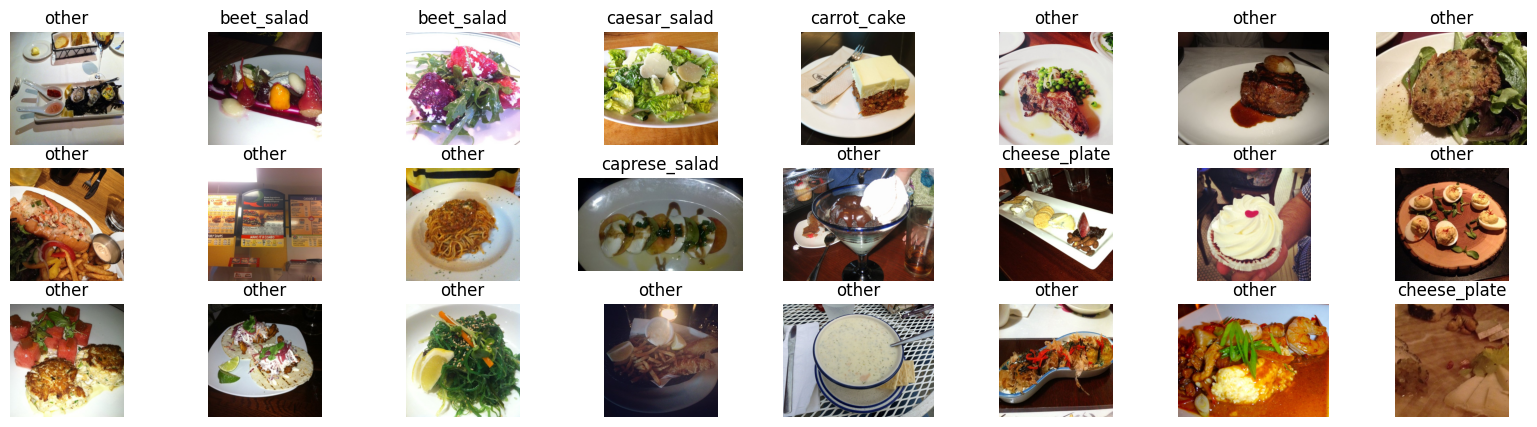

In [6]:
plt.figure(figsize=(20, 5))
num_rows = 3
num_cols = 8
for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])
    label = train_imgs.label.iloc[random_idx]
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [7]:
# Importing necessary libraries
import os
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.utils import shuffle
from PIL import Image
import random
from torch.utils.checkpoint import checkpoint_sequential
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR

# Setting device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reading class names and defining the first 20 classes + 'other'
classes = open("/kaggle/input/food-101/food-101/food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']

# Custom label encoder for 21 classes
class Label_encoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}
    def get_label(self, idx):
        return list(self.labels.keys())[idx]
    def get_idx(self, label):
        return self.labels.get(label)

# Initialize label encoder
encoder_21 = Label_encoder(classes_21)

# Custom Dataset Class for handling image data
class Food21(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        label = encoder_21.get_idx(self.dataframe.label.iloc[idx])

        # Apply transforms without using a named argument for torchvision.transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Function to prepare a DataFrame from a given path with image paths and labels
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()
    img_path = "/kaggle/input/food-101/food-101/food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]
    imgs = []
    for img in array:
        img = img.split('/')
        imgs.append(img)
    imgs = np.array(imgs)
    for idx, img in enumerate(imgs):
        if encoder_21.get_idx(img[0]) is None:
            imgs[idx, 0] = "other"      
    imgs = pd.DataFrame(imgs[:, 0], imgs[:,1], columns=['label'])      
    imgs['path'] = full_path
    imgs = shuffle(imgs)
    return imgs

# Preparing training and testing DataFrames
train_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/train.txt')
test_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/test.txt')

# Custom cutout augmentation class
class CutOut(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        return img

In [9]:
# Data augmentation and transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    CutOut(n_holes=1, length=16)
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [10]:
# Data loaders
trainset = Food21(train_imgs, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

testset = Food21(test_imgs, transform=transform_test)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

In [11]:
# Gradient Checkpointed ResNet152 Model
class CheckpointedResNet152(nn.Module):
    def __init__(self, num_classes=21):
        super(CheckpointedResNet152, self).__init__()
        base_model = models.resnet152(weights='IMAGENET1K_V1')
       
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool

        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4
       
        self.avgpool = base_model.avgpool
        self.fc = nn.Linear(base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
       
        x = checkpoint_sequential(self.layer1, segments=1, input=x)
        x = checkpoint_sequential(self.layer2, segments=1, input=x)
        x = checkpoint_sequential(self.layer3, segments=1, input=x)
        x = checkpoint_sequential(self.layer4, segments=1, input=x)
       
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [12]:
# Initialize model, criterion, optimizer, scaler, and scheduler
model = CheckpointedResNet152(num_classes=21).to(device)
scaler = GradScaler()
model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)

# Scheduler with warm-up and cosine annealing
warmup_epochs = 3
total_epochs = 11
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs),
        CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
    ],
    milestones=[warmup_epochs]
)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 191MB/s]


In [13]:

# Training and testing functions
def train(epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in tqdm(trainloader, desc=f"Training Epoch {epoch + 1}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()

    train_accuracy = 100. * correct_train / total_train
    print(f'Training Loss: {running_loss/len(trainloader):.3f} | Training Accuracy: {train_accuracy:.2f}%')

def test(epoch):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, targets in tqdm(testloader, desc=f"Testing Epoch {epoch + 1}"):
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast(device_type='cuda'):
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    test_accuracy = 100. * correct_test / total_test
    print(f'Test Accuracy after Epoch {epoch + 1}: {test_accuracy:.2f}%')
    return test_accuracy

# Training loop
best_acc = 0.0

for epoch in range(total_epochs):
    train(epoch)
    acc = test(epoch)
    scheduler.step()

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'resnet152_food21_best.pt')
        print(f"Best model saved with accuracy: {best_acc:.2f}%")

print("Training completed.")

Training Epoch 1:   0%|          | 0/2368 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:545: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Training Epoch 1: 100%|██████████| 2368/2368 [13:47<00:00,  2.86it/s]


Training Loss: 0.755 | Training Accuracy: 82.69%


Testing Epoch 1: 100%|██████████| 790/790 [01:47<00:00,  7.32it/s]


Test Accuracy after Epoch 1: 89.71%
Best model saved with accuracy: 89.71%


Training Epoch 2: 100%|██████████| 2368/2368 [13:45<00:00,  2.87it/s]


Training Loss: 0.489 | Training Accuracy: 86.57%


Testing Epoch 2: 100%|██████████| 790/790 [01:37<00:00,  8.11it/s]


Test Accuracy after Epoch 2: 90.78%
Best model saved with accuracy: 90.78%


Training Epoch 3: 100%|██████████| 2368/2368 [13:45<00:00,  2.87it/s]


Training Loss: 0.479 | Training Accuracy: 86.95%


Testing Epoch 3: 100%|██████████| 790/790 [01:37<00:00,  8.11it/s]
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Accuracy after Epoch 3: 90.25%


Training Epoch 4: 100%|██████████| 2368/2368 [13:45<00:00,  2.87it/s]


Training Loss: 0.494 | Training Accuracy: 86.52%


Testing Epoch 4: 100%|██████████| 790/790 [01:37<00:00,  8.07it/s]


Test Accuracy after Epoch 4: 89.27%


Training Epoch 5: 100%|██████████| 2368/2368 [13:45<00:00,  2.87it/s]


Training Loss: 0.453 | Training Accuracy: 87.53%


Testing Epoch 5: 100%|██████████| 790/790 [01:37<00:00,  8.10it/s]


Test Accuracy after Epoch 5: 89.88%


Training Epoch 6: 100%|██████████| 2368/2368 [13:46<00:00,  2.87it/s]


Training Loss: 0.414 | Training Accuracy: 88.47%


Testing Epoch 6: 100%|██████████| 790/790 [01:37<00:00,  8.08it/s]


Test Accuracy after Epoch 6: 90.89%
Best model saved with accuracy: 90.89%


Training Epoch 7: 100%|██████████| 2368/2368 [13:45<00:00,  2.87it/s]


Training Loss: 0.365 | Training Accuracy: 89.64%


Testing Epoch 7: 100%|██████████| 790/790 [01:37<00:00,  8.09it/s]


Test Accuracy after Epoch 7: 92.00%
Best model saved with accuracy: 92.00%


Training Epoch 8: 100%|██████████| 2368/2368 [13:46<00:00,  2.87it/s]


Training Loss: 0.311 | Training Accuracy: 91.14%


Testing Epoch 8: 100%|██████████| 790/790 [01:37<00:00,  8.09it/s]


Test Accuracy after Epoch 8: 92.13%
Best model saved with accuracy: 92.13%


Training Epoch 9: 100%|██████████| 2368/2368 [13:46<00:00,  2.87it/s]


Training Loss: 0.261 | Training Accuracy: 92.44%


Testing Epoch 9: 100%|██████████| 790/790 [01:37<00:00,  8.08it/s]


Test Accuracy after Epoch 9: 93.33%
Best model saved with accuracy: 93.33%


Training Epoch 10: 100%|██████████| 2368/2368 [13:45<00:00,  2.87it/s]


Training Loss: 0.218 | Training Accuracy: 93.69%


Testing Epoch 10: 100%|██████████| 790/790 [01:37<00:00,  8.09it/s]


Test Accuracy after Epoch 10: 93.88%
Best model saved with accuracy: 93.88%


Training Epoch 11: 100%|██████████| 2368/2368 [13:46<00:00,  2.87it/s]


Training Loss: 0.193 | Training Accuracy: 94.49%


Testing Epoch 11: 100%|██████████| 790/790 [01:38<00:00,  8.05it/s]


Test Accuracy after Epoch 11: 93.93%
Best model saved with accuracy: 93.93%
Training completed.
